# *Import Requirements*

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# General & for data storing and processing 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import math
import gc
from itertools import islice
    
# for plotting graphs
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
    
# for images
import cv2 as cv #open-cv
from tensorflow.keras.preprocessing.image import ImageDataGenerator
    
# dealing with files and directories 
import os
import shutil
    
# numeralize classes 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
   
# kfold train-test split
from sklearn.model_selection import StratifiedKFold
   
# for model and layers
import tensorflow
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import regularizers 
    
 # model optimizer
from tensorflow.keras.optimizers import Adam

# Model-callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [2]:
#def import_required():
    
# importing...
#import_required()

In [3]:
#!pip install tensorflow

In [4]:

print(os.listdir('G:/Internship mnit/DATASET VERSIONS/classwise_Unbalanced'))


['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltrate', 'Mass', 'Nodule', 'Normal', 'Pneumonia', 'Pneumothorax']


# *csv file to data-frame*

In [5]:
def csv_to_df():
    orig_data = pd.read_csv('G:/Internship mnit/DATA_CSV/data_csv.csv')
    orig_data = orig_data[["Image Index", "Finding Label"]]
    return orig_data
    
#orig_data = csv_to_df()

# *Original sampling of class*

In [6]:
def plot_bar(data, feature):
    classes = data[feature].value_counts()
    x = np.array(classes.index)
    y = np.array(classes.values)
    fig,ax = plt.subplots(figsize = (12,5))
    ax.bar(x,y)
    
    return

#plot_bar(orig_data, 'Finding Label')         


# *Image Augmentation*

In [7]:
#Return the first n items of the dict.
def take(n, dictionary):
        iterable = dictionary.items()
        return dict(islice(iterable, n))       

######## function for augmentation of images in Array 'X' ########
def augment(target, present, X, dirc):
    
    #parameters for image generator
    dictionary = {'zoom_range' : 0.2, 'width_shift_range' : 0.3, 'featurewise_center' : True, 'samplewise_center' : True, 'featurewise_std_normalization' : True, 
                      'samplewise_std_normalization': True, 'height_shift_range' : 0.3}

    #print(dirc)
    need = target - present
    need_per_img = need/len(X)
            
    if(need == 0):
        genrator = ImageDataGenerator().flow(X, batch_size = len(X), save_to_dir = dirc, save_prefix = 'orig', save_format = 'png')
        next(genrator)
                 
    elif(need_per_img < 1):
        to_aug_index = random.sample(range(0, len(X)), need)
        x =  np.empty(shape = (need, 224,224,3))
            
        i = 0
        for index in to_aug_index:
            x[i] = X[index]
            i += 1
        
        parameters = take(1,dictionary)
        image_data_gen = ImageDataGenerator(**parameters)
        generator = image_data_gen.flow(x, batch_size = len(x), save_to_dir = dirc, save_prefix = 'aug', save_format = 'png')
        next(generator)
        present = present + need
        augment(target,present,X,dirc)
            
    else:
        no_of_param = math.floor(need_per_img)
        parameters = take(no_of_param, dictionary)
        image_data_gen = ImageDataGenerator(**parameters)
        generator = image_data_gen.flow(X, batch_size = len(X), save_to_dir = dirc, save_prefix = 'aug', save_format = 'png')
        next(generator)
        present = present + present * no_of_param
        augment(target,present, X, dirc)
####### augment function ends ###########

# *Balancing the Data using over-sampling*

In [8]:
def balance_data(orig_data, src_dirc, dest_dirc, class_column):

    #shutil.rmtree('/kaggle/working/')   # -- for removing the directory if already present 
    common_path = src_dirc                  
    directories = os.listdir(common_path)
    target = max(orig_data[class_column].value_counts())       
    dest_dirc = dest_dirc                

    if(os.path.isdir(dest_dirc) == True):
        shutil.rmtree(dest_dirc)
    
    os.mkdir(dest_dirc)
    
    for directory in directories:
        dirc = dest_dirc + directory + '/'  
        os.mkdir(dirc)
        files = os.listdir(common_path + directory + '/')
        files = pd.DataFrame(files,columns = ['File Name'])
        files['path'] = common_path + directory + '/' + files['File Name']
        files['pixel_array'] = files['path'].map(lambda x : cv.resize(cv.imread(x), (224,224)))
        
        # .flow() requires rank 4 input array X(no. of images, width, height, axis)
        X = np.empty(shape = (len(files), 224,224,3)) # for RGB axis = 3, for Grayscale axis = 1
        for i in range(len(files)):
            X[i] = files['pixel_array'][i]
            X[i] /= 255.0
        
        print('X shape : ',X.shape)
        
        #calling of augment function
        present = len(X)
        augment(target, present, X, dirc)
        
    #######ARCHIVING OF THE OUTPUT FILE##############     
    #shutil.make_archive('M5', 'zip', '/kaggle/working/')
    
    print('Data balanced in directory : ', dest_dirc)
    return dest_dirc

#bal_dirc = balance_data(orig_data,src_dirc, dest_dirc, class_column)

# *Creating a new data-frame 'bal_data' for balanced data*

In [9]:
def setup_bal_data(bal_dirc):
    
    bal_data = pd.DataFrame(columns = ['File Name', 'Label'])
    #print(bal_data)
    
    directories = os.listdir(bal_dirc)
    
    for directory in directories:
        files = os.listdir(bal_dirc + directory)
        df = pd.DataFrame(files,columns = ['File Name'])
        df['Label'] = directory
        bal_data = bal_data.append(df)
    
    #Adding 'path' as a x_label to 'bal_data' df
    bal_data['path'] = bal_dirc + bal_data['Label'] + '/' + bal_data['File Name']
    
    # Adding class vector as a y vector
    class_enc = LabelEncoder()
    bal_data['class_id'] = class_enc.fit_transform(bal_data['Label'])
    oh_enc = OneHotEncoder(sparse=False)
    bal_data['class_vector'] = oh_enc.fit_transform(bal_data['class_id'].values.reshape(-1, 1)).tolist()

    #print(bal_data.head().to_markdown())
    
    
    return bal_data

#bal_data = setup_bal_data(bal_dirc)

# *Shuffle and Train-Test split*

In [10]:
def train_test_split(bal_data, test_dirc, train_frac):  # bal_data = data to be split,  test_dirc = directory at which User want test data

    shuffled_data = bal_data.sample(frac = 1).reset_index(drop = True)
    total_rows = len(shuffled_data)
    train_rows = int(train_frac * total_rows)

    train_data = shuffled_data[0:train_rows - 1]
    test_data = shuffled_data[train_rows : total_rows - 1]
    
    # If test data already present at folder -> remove the folder 
    if(os.path.isdir(test_dirc) == True):
        shutil.rmtree(test_dirc)
        
    os.mkdir(test_dirc)

    ## test-data seprated at new location
    test_data.set_index('File Name', inplace = True)
    for file in test_data.index:
        shutil.move(test_data.loc[file]['path'], test_dirc + file)
    
    ## viewing & plotting train data
    #print('train_data : \n',train_data.head().to_markdown())
    #plot_bar(train_data, 'Label')
    #print('\ntrain_data length : ',len(train_data))

    ## viewing & plotting test data
    #print('\ntest_data : \n',test_data.head().to_markdown())
    #plot_bar(test_data, 'Label')
    #print('test_data length : ',len(test_data))
    
    return {'train_data' : train_data, 'test_data' : test_data}


#test_dirc = '/kaggle/working/test_data/'
#split_data = train_test_split(bal_data, test_dirc) 
#train_data = split_data['train_data']
#test_data = split_data['test_data']

# *Selecting the model and setting up the hyperparameter*

In [1]:
def set_hyperparameters(BASE_MODEL = 'RESNET52', EPOCHS = 100, INPUT_SHAPE = (224,224,3), DENSE_COUNT_HIDDEN_LAYER = 512, DENSE_COUNT_OUTPUT_LAYER = 9, LEARNING_RATE = 0.0003,
                        DROPOUT_1 = 0.4, DROPOUT_2 = 0.3, BATCH_SIZE = 16, STEPS_PER_EPOCH = 89, VALIDATION_STEPS = 22, REGULARIZATION_LAMBDA = 0) :

    # returns func arguments as a dictionary
    h_parameters = locals()
    
    if BASE_MODEL=='VGG16':
        from tensorflow.keras.applications.vgg16 import VGG16 as Model, preprocess_input
    elif BASE_MODEL=='RESNET52':
        from tensorflow.keras.applications.resnet50 import ResNet50 as Model, preprocess_input
    elif BASE_MODEL=='InceptionV3':
        from tensorflow.keras.applications.inception_v3 import InceptionV3 as Model, preprocess_input
    elif BASE_MODEL=='Xception':
        from tensorflow.keras.applications.xception import Xception as Model, preprocess_input
    elif BASE_MODEL=='DenseNet169': 
        from tensorflow.keras.applications.densenet import DenseNet169 as Model, preprocess_input
    elif BASE_MODEL=='DenseNet121':
        from tensorflow.keras.applications.densenet import DenseNet121 as Model, preprocess_input
    else:
        raise ValueError('Unknown model: {}'.format(BASE_MODEL))
    
    return {'Model' : Model, 'preprocess_input' : preprocess_input, 'h_parameters' : h_parameters}


#parameters = set_hyperparameters()
#h_parameters = parameters['h_parameters']

# *Setting up the pre-trained-model*

In [2]:
def set_ptm(parameters):
    
    Model =  parameters['Model']
    h_parameters = parameters['h_parameters']
    
    Pre_trained_model = Model(input_shape = h_parameters['INPUT_SHAPE'], include_top = False, weights = 'imagenet')
    Pre_trained_model.trainable = False
    for layer in Pre_trained_model.layers:
        layer.trainable = False
    
    Pre_trained_model.summary()
    return Pre_trained_model

#ptm = set_ptm(parameters)

# *Creating the TL Model by flatning the last layer o/p of PTM and adding dense layer to it.* 

In [13]:
def create_TL_model(Pre_trained_model, h_parameters): 
    
    DROPOUT_1 = h_parameters['DROPOUT_1']
    DROPOUT_2 = h_parameters['DROPOUT_2']
    REGULARIZATION_LAMBDA = h_parameters['REGULARIZATION_LAMBDA']
    DENSE_COUNT_HIDDEN_LAYER = h_parameters['DENSE_COUNT_HIDDEN_LAYER']
    DENSE_COUNT_OUTPUT_LAYER = h_parameters['DENSE_COUNT_OUTPUT_LAYER']
    

    # setting a layer trainable:
    Pre_trained_model.get_layer('block5_conv3').trainable = True
    
    # getting the last layer
    ptm_last_layer = Pre_trained_model.get_layer('block5_pool')
    print("pre-trained-model last layer o/p shape  :", ptm_last_layer.output_shape)
    last_layer_output = ptm_last_layer.output

    add_on = GlobalAveragePooling2D()(last_layer_output)
    add_on = Dropout(DROPOUT_1)(add_on)
    add_on = Dense(units = DENSE_COUNT_HIDDEN_LAYER,kernel_regularizer = regularizers.l2(REGULARIZATION_LAMBDA) ,activation = 'relu')(add_on)
    add_on = Dropout(DROPOUT_1)(add_on)

    # Adding the 9-class output layer
    add_on = Dense(units = DENSE_COUNT_OUTPUT_LAYER, kernel_regularizer = regularizers.l2(REGULARIZATION_LAMBDA), activation = 'softmax')(add_on)

    TL_model = Model(Pre_trained_model.input, add_on)
             
    TL_model.summary()
    
    return TL_model

#TL_model = create_TL_model(ptm, h_parameters)

# *Model Optimization*

In [14]:
def compile_model(TL_model, h_parameter):
    TL_model.compile(optimizer = Adam(learning_rate = h_parameter['LEARNING_RATE']), metrics = ['categorical_accuracy'], loss = 'categorical_crossentropy')

#compile_model(TL_model)

In [15]:
#!ls -ld /kaggle/working/*

# *Image Data Generator*

In [16]:
def generate_images(h_parameters):
     
    train_data_gen = ImageDataGenerator(shear_range = 0.1, zoom_range = 0.2, height_shift_range = 0.1, width_shift_range = 0.1, fill_mode = 'nearest',rotation_range = 1)
    valid_data_gen = ImageDataGenerator()
    #train_gen = img_data_gen.flow_from_directory('/kaggle/working/balanced_data/', class_mode = "sparse", batch_size = h_parameters['BATCH_SIZE'], subset = 'training', target_size = (224,224), shuffle = True)
    #valid_gen = valid_data_gen.flow_from_directory('/kaggle/working/balanced_data/',class_mode = None, batch_size = h_parameters['BATCH_SIZE'], subset = 'validation', target_size = (224,224), shuffle = True)
    #print(train_gen.samples)
    #print(valid_gen.samples)
    
    return {'train_img_gen' : train_data_gen, 'valid_img_gen' : valid_data_gen}

#generators = generate_images()
#train_gen = generators['train_gen']
#valid_gen = generators['valid_gen']

# *Code for Early stopping*

In [17]:
def callbacks():
    
    weight_path="{}_weights.best.hdf5".format('lung_opacity')

    checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, 
                                   patience=20, verbose=1, mode='auto', 
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
    early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=20) # probably needs to be more patient, but kaggle time is limited
    callbacks_list = [checkpoint, early, reduceLROnPlat]
    
    return callbacks_list

#callback_list = callbacks()

# *Training the model*

In [18]:
def train_model(model, train_gen, valid_gen, h_parameters):
    
    # steps_per_epoch = (training size//batch size)
    history = model.fit(train_gen, validation_data = valid_gen, epochs = h_parameters['EPOCHS'], steps_per_epoch = h_parameters['STEPS_PER_EPOCH'] , validation_steps = h_parameters['VALIDATION_STEPS'], workers = os.cpu_count())
    return history

#history = train_model(TL_model, train_gen, valid_gen)

# *Evaluating the results*

In [19]:
def plot_results(history):
    results = history.history
    loss = results['loss']
    categorical_accuracy = results['categorical_accuracy']
    val_loss = results['val_loss']
    val_categorical_accuracy = results['val_categorical_accuracy']
    
    plt.subplots(figsize = (14,5))
    plt.subplot(1,2,1)
    plt.title(label = "Accuracy  v/s epochs")
    plt.plot(categorical_accuracy, 'r-', label = 'Training Accuracy')
    plt.plot(val_categorical_accuracy, 'b-', label = 'Validation Accuracy')
    plt.xlabel('EPOCHS')
    plt.ylabel('ACCURACY')
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(label = "Loss  v/s epochs")
    plt.plot(loss, 'r-', label = 'Training Loss')
    plt.plot(val_loss, 'b-', label = 'Validation Loss')
    plt.xlabel('EPOCHS')
    plt.ylabel('LOSS')
    plt.legend()
    
    plt.tight_layout(pad = 4)
    plt.show()
    
#plot_results(history)

# *Saving the results history*

In [20]:
def save_history_to_results(history, h_parameters):
    
    hyper_parameters = h_parameters
    result_history.append([history , hyper_parameters])
    print('Total results : ',len(result_history))
    return result_history

#result_history = save_history_to_results(history, h_parameters)

In [25]:
def view_results(result_history):
    
    #print('lets run the model for VGG16, 100 epochs, (224,224) input, 512 hidden layer inputs, 9 o/p layer neurons, DROPOUT = (0.5,0.4), 16 batch_size, 60 steps / EPOCH, NO Regularization (just dropouts)')
    #print('We will run for different learning rates : 1e-2, 3 *1 e-2, 1e-3, 3 * 1e-3, 1e-4 ')
    for item in result_history:
        hist = item[0]
        h_parameters = item[1]
        print('parameters : \n')
    
        i = 0
        for parameter in h_parameters:
            print(h_parameters)
            i = i+1
        plot_results(hist)
    
        print('\n\n')


# *Saving the model*

In [22]:
def save_model(model, location):

    if(os.path.isdir(location)):
        shutil.rmtree(location)
    
    TL_model.save(location)
    
#location = '/kaggle/working/saved_models/' + h_parameters['BASE_MODEL'] + '/'
#save_model(TL_model, location )

# *Running the script*

X shape :  (180, 224, 224, 3)
X shape :  (146, 224, 224, 3)
X shape :  (153, 224, 224, 3)
X shape :  (123, 224, 224, 3)
X shape :  (85, 224, 224, 3)
X shape :  (79, 224, 224, 3)
X shape :  (200, 224, 224, 3)
X shape :  (120, 224, 224, 3)
X shape :  (98, 224, 224, 3)
Data balanced in directory :  G:/Internship mnit/DATASET VERSIONS/classwise_balanced/


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9552\2164835465.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9552\2164835465.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9552\2164835465.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9552\2164835465.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  bal_data = bal_data.append(df)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9552\2164835465.py:

train_samples 1799
test_samples 0
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)

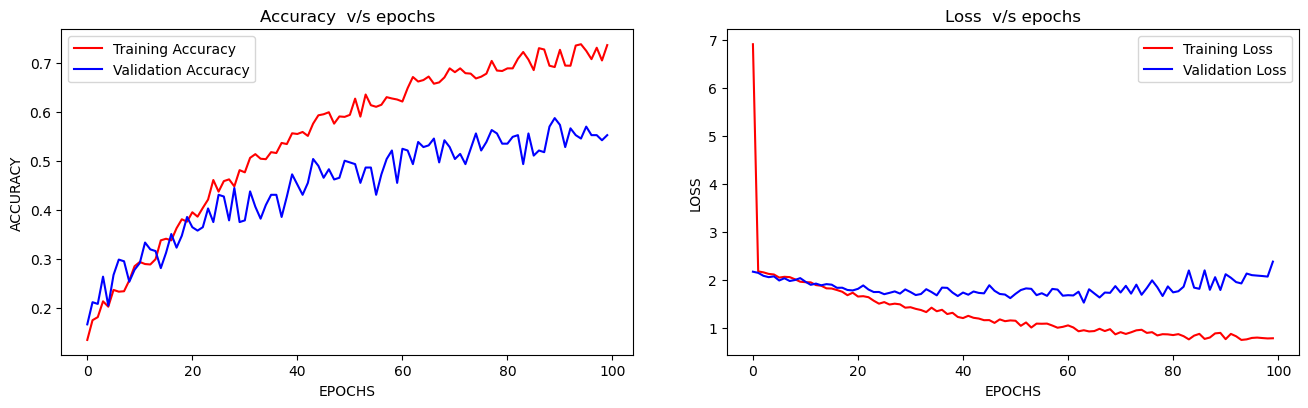

Total results :  1

fold 1 : 
train_samples :  1439
valid_samples :  360
Found 1439 validated image filenames belonging to 9 classes.
Found 360 validated image filenames belonging to 9 classes.
Epoch 1/100
70/70 [==============================] - 16s 217ms/step - loss: 1.2286 - categorical_accuracy: 0.6250 - val_loss: 0.4694 - val_categorical_accuracy: 0.8715
Epoch 2/100
70/70 [==============================] - 16s 216ms/step - loss: 1.0694 - categorical_accuracy: 0.6461 - val_loss: 0.4554 - val_categorical_accuracy: 0.8264
Epoch 3/100
70/70 [==============================] - 16s 216ms/step - loss: 1.0262 - categorical_accuracy: 0.6479 - val_loss: 0.4313 - val_categorical_accuracy: 0.8646
Epoch 4/100
70/70 [==============================] - 16s 217ms/step - loss: 0.9897 - categorical_accuracy: 0.6696 - val_loss: 0.3888 - val_categorical_accuracy: 0.8750
Epoch 5/100
70/70 [==============================] - 16s 217ms/step - loss: 0.9871 - categorical_accuracy: 0.6819 - val_loss: 0.4537 -

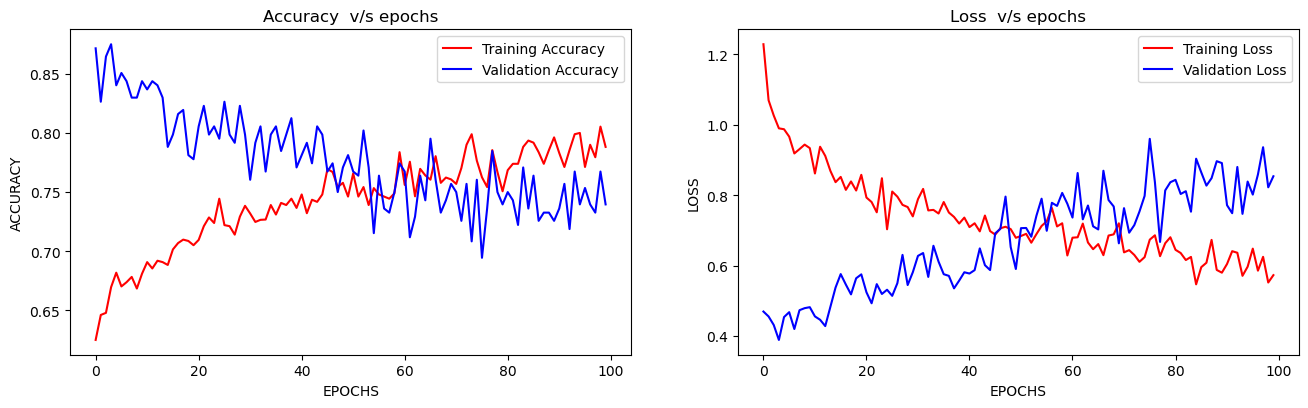

Total results :  2

fold 2 : 
train_samples :  1439
valid_samples :  360
Found 1439 validated image filenames belonging to 9 classes.
Found 360 validated image filenames belonging to 9 classes.
Epoch 1/100
70/70 [==============================] - 16s 218ms/step - loss: 0.7900 - categorical_accuracy: 0.7507 - val_loss: 0.2163 - val_categorical_accuracy: 0.9132
Epoch 2/100
70/70 [==============================] - 16s 218ms/step - loss: 0.7476 - categorical_accuracy: 0.7516 - val_loss: 0.2535 - val_categorical_accuracy: 0.9201
Epoch 3/100
70/70 [==============================] - 16s 217ms/step - loss: 0.7943 - categorical_accuracy: 0.7348 - val_loss: 0.2144 - val_categorical_accuracy: 0.9271
Epoch 4/100
70/70 [==============================] - 16s 216ms/step - loss: 0.7340 - categorical_accuracy: 0.7321 - val_loss: 0.2334 - val_categorical_accuracy: 0.9097
Epoch 5/100
70/70 [==============================] - 16s 217ms/step - loss: 0.6994 - categorical_accuracy: 0.7578 - val_loss: 0.2538 -

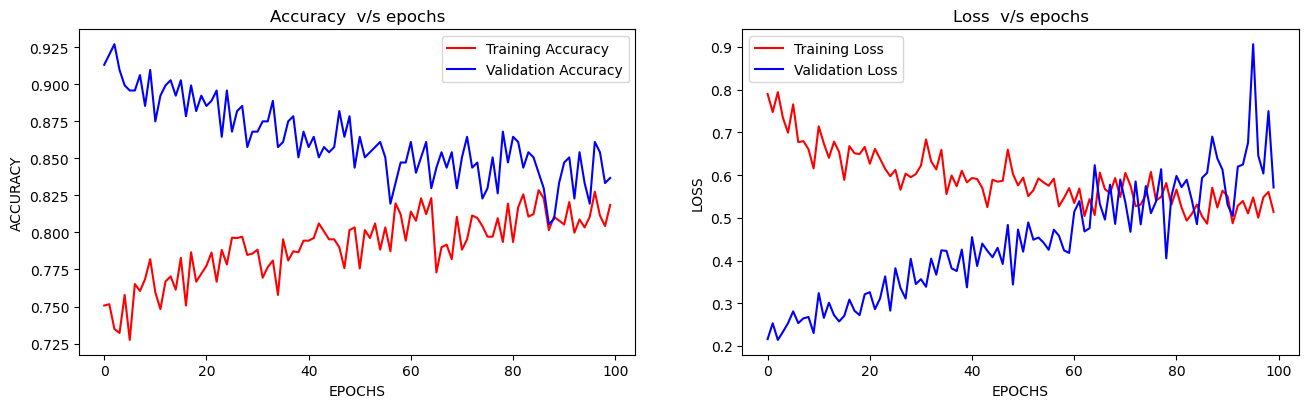

Total results :  3

fold 3 : 
train_samples :  1439
valid_samples :  360
Found 1439 validated image filenames belonging to 9 classes.
Found 360 validated image filenames belonging to 9 classes.
Epoch 1/100
70/70 [==============================] - 16s 218ms/step - loss: 0.7331 - categorical_accuracy: 0.7730 - val_loss: 0.1850 - val_categorical_accuracy: 0.9514
Epoch 2/100
70/70 [==============================] - 16s 217ms/step - loss: 0.7077 - categorical_accuracy: 0.7802 - val_loss: 0.2184 - val_categorical_accuracy: 0.9236
Epoch 3/100
70/70 [==============================] - 16s 217ms/step - loss: 0.6197 - categorical_accuracy: 0.7909 - val_loss: 0.1993 - val_categorical_accuracy: 0.9167
Epoch 4/100
70/70 [==============================] - 16s 217ms/step - loss: 0.5985 - categorical_accuracy: 0.7918 - val_loss: 0.2104 - val_categorical_accuracy: 0.9097
Epoch 5/100
70/70 [==============================] - 16s 216ms/step - loss: 0.6021 - categorical_accuracy: 0.7909 - val_loss: 0.2401 -

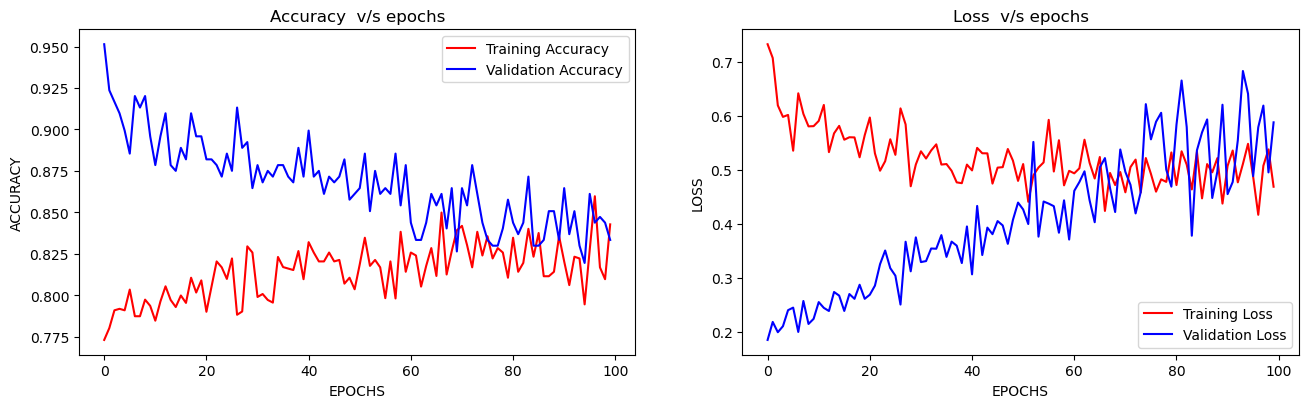

Total results :  4

fold 4 : 
train_samples :  1440
valid_samples :  359
Found 1440 validated image filenames belonging to 9 classes.
Found 359 validated image filenames belonging to 9 classes.
Epoch 1/100
70/70 [==============================] - 16s 218ms/step - loss: 0.6229 - categorical_accuracy: 0.7937 - val_loss: 0.1322 - val_categorical_accuracy: 0.9479
Epoch 2/100
70/70 [==============================] - 16s 216ms/step - loss: 0.6256 - categorical_accuracy: 0.7741 - val_loss: 0.1434 - val_categorical_accuracy: 0.9479
Epoch 3/100
70/70 [==============================] - 16s 217ms/step - loss: 0.5785 - categorical_accuracy: 0.7982 - val_loss: 0.1626 - val_categorical_accuracy: 0.9479
Epoch 4/100
70/70 [==============================] - 16s 216ms/step - loss: 0.5769 - categorical_accuracy: 0.8080 - val_loss: 0.1460 - val_categorical_accuracy: 0.9549
Epoch 5/100
70/70 [==============================] - 16s 216ms/step - loss: 0.5440 - categorical_accuracy: 0.7991 - val_loss: 0.1465 -

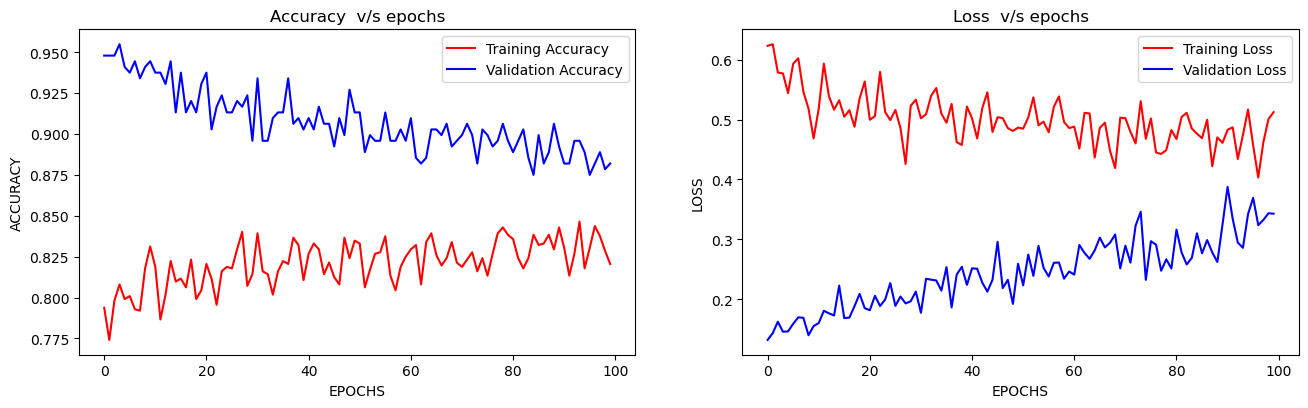

Total results :  5


In [23]:
# importing required libraries
#import_required()

import tensorflow

#csv_data to df
orig_data = csv_to_df()

# original sampling of data
#plot_bar(orig_data, 'Finding Label')

# balancing no. of images in each class
src_dirc = 'G:/Internship mnit/DATASET VERSIONS/classwise_Unbalanced/'
dest_dirc = 'G:/Internship mnit/DATASET VERSIONS/classwise_balanced/'
class_column = 'Finding Label'

if(os.path.isdir(dest_dirc) == True):
    shutil.rmtree(dest_dirc)

bal_dirc = balance_data(orig_data, src_dirc, dest_dirc, class_column)

# setting up balance data df
bal_data = setup_bal_data(bal_dirc)

# train-test split
test_dirc = 'G:/Internship mnit/DATASET VERSIONS/test_data/'
split_data = train_test_split(bal_data, test_dirc, 1)
train_and_val_data = split_data['train_data']
test_data = split_data['test_data']

print('train_samples',len(train_and_val_data))
print('test_samples',len(test_data))

skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(train_and_val_data['path'], train_and_val_data['class_id'])    

result_history = []

# choose model, preprocess_input, hyper-parameters
parameters = set_hyperparameters(LEARNING_RATE = 0.0009, DROPOUT_1 = 0.4,  DROPOUT_2 = 0.3, EPOCHS = 100)
h_parameters = parameters['h_parameters']

# setting up pre-trained-model
ptm = set_ptm(parameters)

# create TL model by adding up of layers
TL_model = create_TL_model(ptm, h_parameters)
    
# compile the model
compile_model(TL_model, h_parameters)
    

for i, (train_index, test_index) in enumerate(skf.split(train_and_val_data['path'], train_and_val_data['class_id'])):
    print(f"\nfold {i} : ")
    # seprate test data from train data
    train_data = train_and_val_data.loc[train_index]
    train_data['class_id'] = train_data['class_id'].astype(str)
    
    
    valid_data  = train_and_val_data.loc[test_index]
    valid_data['class_id'] = valid_data['class_id'].astype(str)
    print('train_samples : ',len(train_data))
    print('valid_samples : ',len(valid_data))
 
    # Image augmentation using generators
    generators = generate_images(h_parameters)
    train_data_gen = generators['train_img_gen']
    valid_data_gen = generators['valid_img_gen']
    
    train_gen = train_data_gen.flow_from_dataframe(train_data, x_col = 'path', y_col = 'class_id', target_size = (224,224), class_mode = 'categorical', batch_size = h_parameters['BATCH_SIZE'])
    valid_gen = valid_data_gen.flow_from_dataframe(valid_data, x_col = 'path', y_col = 'class_id', target_size = (224,224), class_mode = 'categorical', batch_size = h_parameters['BATCH_SIZE'])
    
    # train_model
    history = train_model(TL_model, train_gen, valid_gen, h_parameters)
    
    # plot model results
    plot_results(history)
    
    # saving the model_history
    result_history = save_history_to_results(history, h_parameters)

parameters : 

{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LA

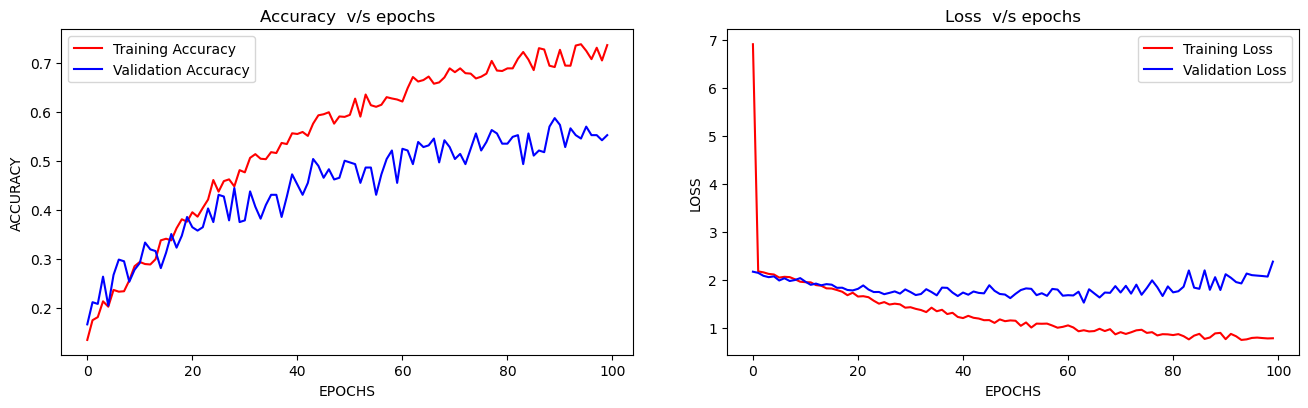




parameters : 

{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT

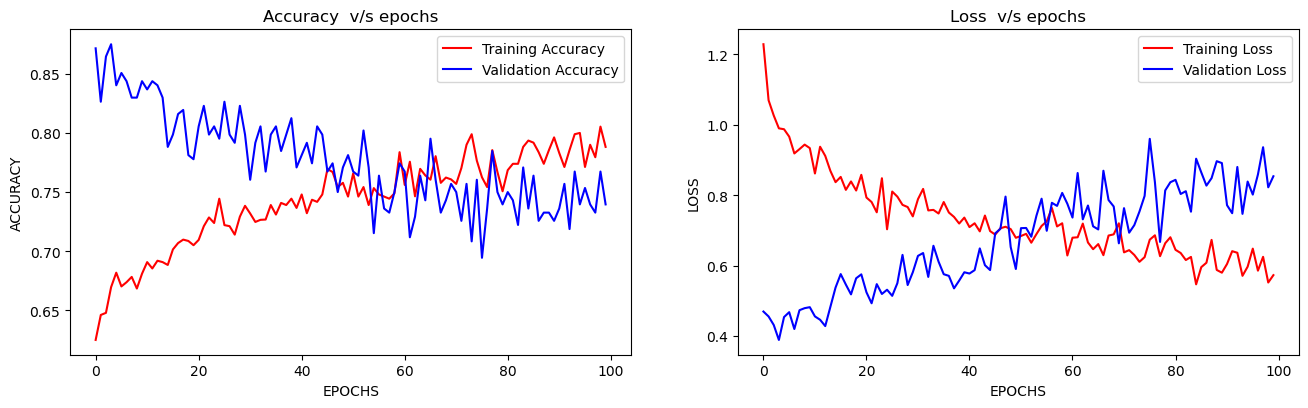




parameters : 

{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT

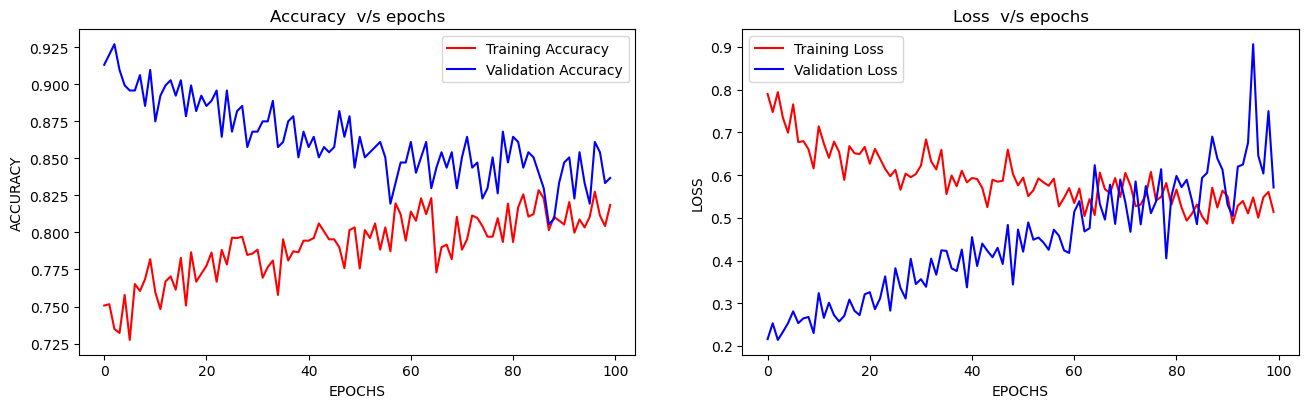




parameters : 

{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT

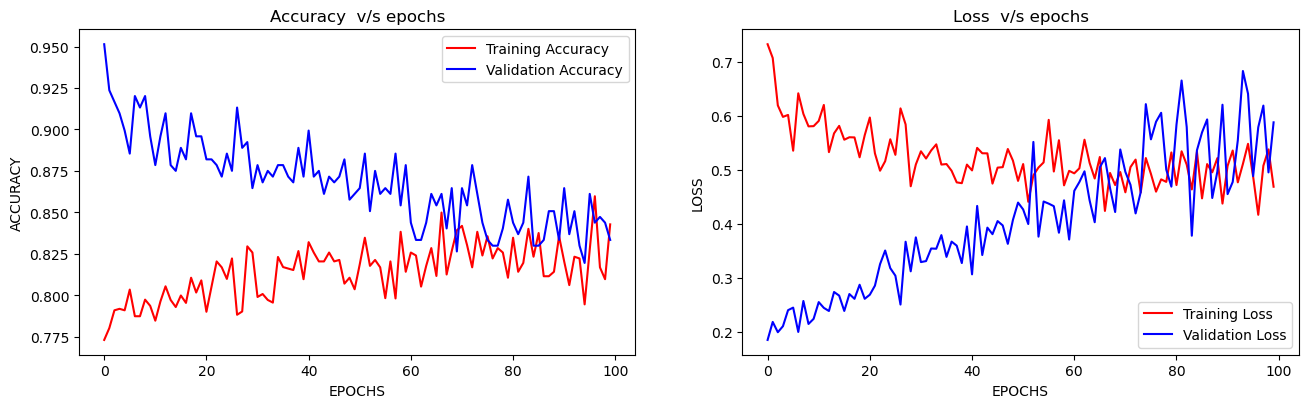




parameters : 

{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT_LAYER': 9, 'LEARNING_RATE': 0.0009, 'DROPOUT_1': 0.4, 'DROPOUT_2': 0.3, 'BATCH_SIZE': 16, 'STEPS_PER_EPOCH': 70, 'VALIDATION_STEPS': 18, 'REGULARIZATION_LAMBDA': 0}
{'BASE_MODEL': 'VGG16', 'EPOCHS': 100, 'INPUT_SHAPE': (224, 224, 3), 'DENSE_COUNT_HIDDEN_LAYER': 512, 'DENSE_COUNT_OUTPUT

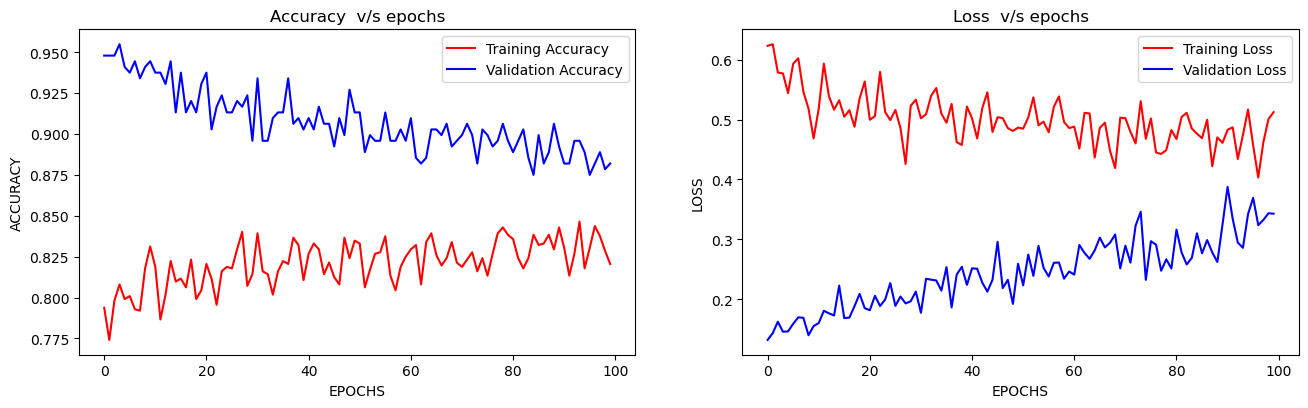

In [26]:
view_results(result_history)

In [28]:
location = 'G:/Internship mnit/results/'
save_model(TL_model, location)

INFO:tensorflow:Assets written to: G:/Internship mnit/results/assets


INFO:tensorflow:Assets written to: G:/Internship mnit/results/assets


In [2]:
import tensorflow

# PREPARING TEST SET
test_data = pd.read_csv("G:/Internship mnit/DATA_CSV/test_csv.csv")
test_data['path'] = "G:/Internship mnit/DATASET VERSIONS/test_data/" + test_data['Image Index'] 
test_data['class_id'] = test_data['class_id'].astype(str)
    

test_img_gen = ImageDataGenerator()

test_gen = test_img_gen.flow_from_dataframe(test_data, x_col = 'path', y_col = 'class_id', target_size = (224,224), class_mode = 'categorical', batch_size = 1, shuffle = False)

# loading the model
model = tensorflow.keras.models.load_model('G:/Internship mnit/results/vgg16Model/')

prediction = model.predict(test_gen)


Found 334 validated image filenames belonging to 9 classes.
334/334 [==============================] - 51s 45ms/step


In [3]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(prediction, axis = 1)
y_test = np.array(test_data['class_id'].astype(int))

print(y_pred)
print(y_test)

confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, y_pred, target_names=['Class 1', 'Class 2', 'Class 3', 'class 4', 'class 5', 'class 6', 'class 7', 'class 8', 'class 9']))



[0 2 1 2 1 0 2 0 5 1 7 8 3 7 5 6 0 8 7 1 6 0 6 5 6 7 1 3 0 1 6 6 1 6 7 6 6
 7 3 7 2 3 5 7 7 5 0 1 0 7 3 0 1 6 5 1 2 4 1 0 2 2 2 1 7 2 3 0 2 1 6 7 6 1
 0 0 2 1 8 0 7 2 7 0 0 1 2 8 5 0 1 1 6 6 1 1 1 1 7 1 1 1 1 5 2 1 1 6 1 1 6
 3 1 5 1 1 1 1 2 1 1 1 1 7 2 1 0 1 1 3 3 1 1 1 5 2 1 0 6 0 0 2 0 0 7 1 2 6
 2 1 0 0 6 0 0 0 6 0 0 3 0 6 0 6 6 0 6 0 6 1 0 0 1 0 5 5 3 2 7 8 8 6 4 1 2
 6 7 6 0 5 6 1 0 5 5 6 6 5 6 3 2 6 2 6 6 8 5 7 5 4 0 6 5 0 2 7 2 7 8 7 7 1
 7 7 5 5 0 0 5 1 0 0 2 0 1 7 3 5 0 0 7 6 8 2 7 2 6 7 6 1 5 8 2 7 7 7 7 0 2
 0 6 2 1 6 0 5 0 0 5 0 1 0 7 1 1 5 5 5 5 0 0 2 5 4 5 1 1 0 7 4 5 5 4 5 6 6
 0 1 6 7 7 6 7 5 0 2 6 5 3 0 6 2 3 6 6 1 3 1 7 5 2 2 8 1 6 5 5 0 1 5 1 7 4
 7]
[7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 